<a href="https://colab.research.google.com/github/AKupriichuk/skin_cancer_cnn/blob/main/skin_cancer_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import io
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import copy
from google.colab import drive
drive.mount('/content/drive')
h5_path = '/content/drive/MyDrive/train-image.hdf5'

csv_path = '/content/drive/MyDrive/train-metadata.csv'

Mounted at /content/drive


In [ ]:
# small example how to open an hdf5 file

# Open the HDF5 file
with h5py.File(h5_path, 'r') as file:
    # Print the file object
    print(file)

    # List the first 5 keys (datasets) in the file
    print("First 5 keys in the file:", list(file.keys())[:5])

    # Access a specific dataset (e.g., 'ISIC_0015670')
    dataset_name = 'ISIC_0015670'  # Replace with your dataset name
    image_data = file[dataset_name]

    # Print dataset information
    print(f"Dataset '{dataset_name}' shape: {image_data.shape}")
    print(f"Dataset '{dataset_name}' dtype: {image_data.dtype}")
    print(f"Dataset '{dataset_name}' contents: {image_data[()]}")

    # Use PIL to open the image
    image = Image.open(io.BytesIO(image_data[()]))

<HDF5 file "train-image.hdf5" (mode r)>
First 5 keys in the file: ['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200']
Dataset 'ISIC_0015670' shape: ()
Dataset 'ISIC_0015670' dtype: |S3325
Dataset 'ISIC_0015670' contents: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8b\x00\x8b\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\

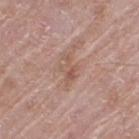

In [ ]:
# looking at the image
image

In [ ]:
# this is used to add padding or crop the images so they are all of the same size
# adjust this as you wish
max_img_size = 128

class HDF5Dataset(Dataset):
    def __init__(self, h5_file, csv_file, train=True, split_ratio=0.2, random_state=42, undersample=False):
        self.h5_file = h5_file

        with h5py.File(h5_file, 'r') as file:
            self.keys = list(file.keys())

        self.metadata_df = pd.read_csv(csv_file)
        self.target_mapping = self.metadata_df.set_index('isic_id')['target'].to_dict()
        self.targets = [self.target_mapping[key] for key in self.keys]

        # means and standard deviations of the entire dataset
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])

        # before we do anything else, we should try to undersample our data, i. e. remove some of the healthy samples
        # here, I am keeping as many healthy patients as there are sick ones
        # this massively reduces the size of our data, and we should find a way to use more data later
        if undersample:
          self._undersample()
        self.length = len(self.keys)

        # Perform stratified train-validation split
        train_indices, val_indices = train_test_split(np.arange(self.length),
                                                      test_size=split_ratio,
                                                      stratify=self.targets,
                                                      random_state=random_state)

        if train:
            self.indices = train_indices
        else:
            self.indices = val_indices

        print(f"Initialized {'train' if train else 'validation'} dataset")
        print("Number of samples:", len(self.indices))

    def _undersample(self):
        # Separate the indices of the two classes
        class_0_indices = [i for i, target in enumerate(self.targets) if target == 0]
        class_1_indices = [i for i, target in enumerate(self.targets) if target == 1]

        # Limit class 0 samples to the number of class 1 samples
        if len(class_0_indices) > len(class_1_indices):
            np.random.shuffle(class_0_indices)
            class_0_indices = class_0_indices[:len(class_1_indices)]

        # Combine the indices
        undersampled_indices = class_0_indices + class_1_indices
        np.random.shuffle(undersampled_indices)

        # Filter the keys and targets based on the undersampled indices
        self.keys = [self.keys[i] for i in undersampled_indices]
        self.targets = [self.targets[i] for i in undersampled_indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]  # Get index from selected subset

        with h5py.File(self.h5_file, 'r') as f:
            data_in_bytes = f[self.keys[true_idx]][()]
            # normalizing the image so that our values are in the range of 0-1
            image = np.array(Image.open(io.BytesIO(data_in_bytes)).convert('RGB'))

            # normalization (so that all values are between 0 and 1)
            X = np.array(image) / 255

            # standardization (so that the mean of the entire dataset is 0 and the std is 1)
            X = (X - self.mean) / self.std
            y = self.targets[true_idx]

            # adding padding
            X = self._pad_image(X)

        return torch.tensor(X, dtype=torch.float32).permute(2, 0, 1), torch.tensor(y, dtype=torch.int8)

    def _pad_image(self, image, max_img_size=max_img_size):
      # if an image is smaller than the max image size, a padding is added
      # if it is larger, it gets cropped

      # Get the dimensions of the image
      height, width, channels = image.shape

      if height < max_img_size or width < max_img_size:
          # Padding the image to max_img_size x max_img_size if it's smaller
          pad_height = (max_img_size - height) // 2
          pad_width = (max_img_size - width) // 2

          padded_image = np.pad(image,
                                ((pad_height, max_img_size - height - pad_height),
                                (pad_width, max_img_size - width - pad_width),
                                (0, 0)),
                                mode='constant',
                                constant_values=0)
          return padded_image

      else:
          # Cropping the image to max_img_size x max_img_size if it's larger
          start_y = (height - max_img_size) // 2
          start_x = (width - max_img_size) // 2
          cropped_image = image[start_y:start_y + max_img_size, start_x:start_x + max_img_size, :]
          return cropped_image

    def get_image_by_index(self, idx):
        true_idx = self.indices[idx]  # Get index from selected subset
        with h5py.File(self.h5_file, 'r') as f:
            data_in_bytes = f[self.keys[true_idx]][()]
            image = np.array(Image.open(io.BytesIO(data_in_bytes)).convert('RGB'))

            # Padding the image to max_img_size x max_img_size if it's smaller
            image = self._pad_image(image)

        return image

    def show_image_by_index(self, idx):
        image = self.get_image_by_index(idx)
        plt.imshow(image)
        plt.axis('off')
        plt.show()


In [ ]:
# Instantiate train and validation datasets
train_dataset = HDF5Dataset(h5_path, csv_path, train=True, split_ratio=0.2, undersample=True)
val_dataset = HDF5Dataset(h5_path, csv_path, train=False, split_ratio=0.2, undersample=True)

<ipython-input-4-4a2ab8d4e90d>:12: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.metadata_df = pd.read_csv(csv_file)


Initialized train dataset
Number of samples: 628


<ipython-input-4-4a2ab8d4e90d>:12: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.metadata_df = pd.read_csv(csv_file)


Initialized validation dataset
Number of samples: 158


In [ ]:
# note that we have removed almost all images by performing undersampling
# our model will likely not generalize well as a result, but we can try deliberately overfitting on the training data
print(len(train_dataset))
print(len(val_dataset))

628
158


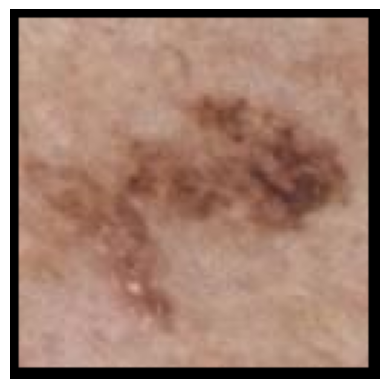

In [ ]:
# example for how to display an image
train_dataset.show_image_by_index(2)

In [ ]:
# assembling data loaders
batch_size = 32  # number of images per batch
num_workers = 4  # number of workers that can work in parallel

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
print(f"Number of batches in train dataloader: {len(train_dataloader)} ({len(train_dataloader) * batch_size} samples)")
print(f"Number of batches in val dataloader: {len(val_dataloader)} ({len(val_dataloader) * batch_size} samples)")

Number of batches in train dataloader: 20 (640 samples)
Number of batches in val dataloader: 5 (160 samples)


In [ ]:
import torch

# Check if CUDA (GPU acceleration) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
else:
    print("CUDA (GPU acceleration) is not available. Running on CPU.")

Number of GPUs available: 1


In [ ]:
def plot_normalized_and_normal_image(idx):
  # plotting the corresponding normal image
  raw_image = train_dataset.get_image_by_index(idx)

  # plotting a normalized image
  X0, y0 = train_dataset[idx]
  normalized_image = X0.permute(1, 2, 0).numpy()

  fix, ax = plt.subplots(1, 2, figsize=(6, 3))
  ax[0].imshow(raw_image)
  ax[1].imshow(normalized_image)
  # turning off the axis ticks
  ax[0].axis('off')
  ax[1].axis('off')
  # setting titles
  ax[0].set_title('Raw image')
  ax[1].set_title('Normalized and\nstandardized image')
  plt.show()

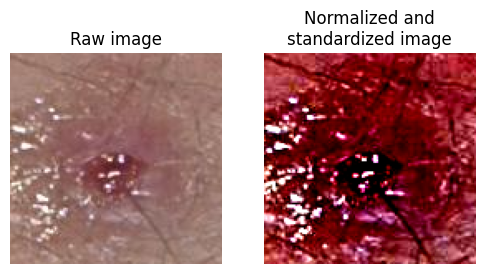

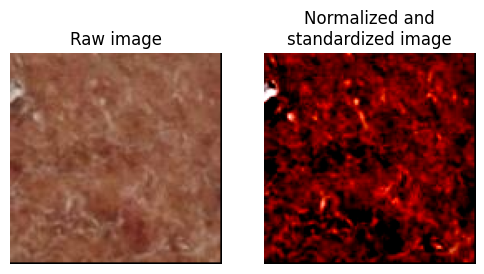

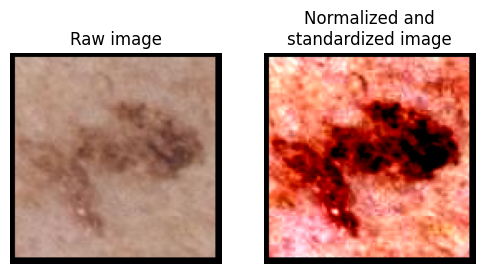

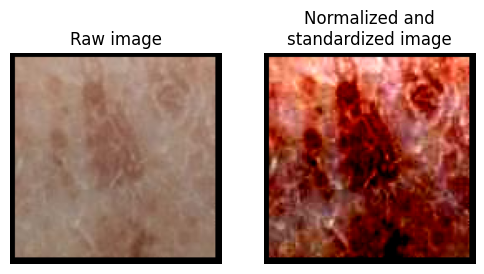

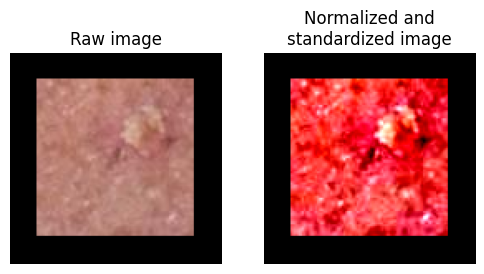

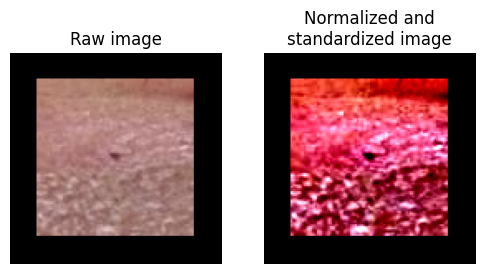

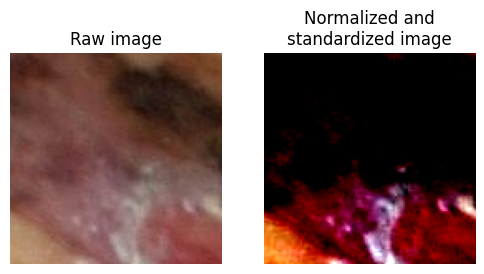

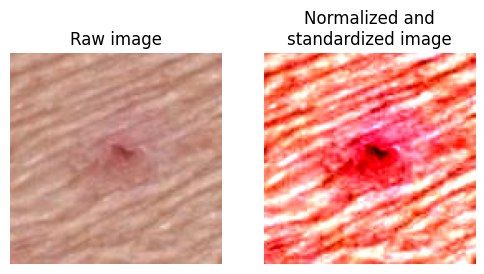

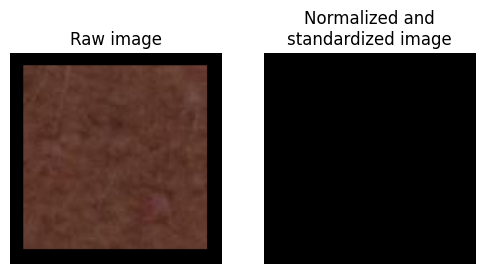

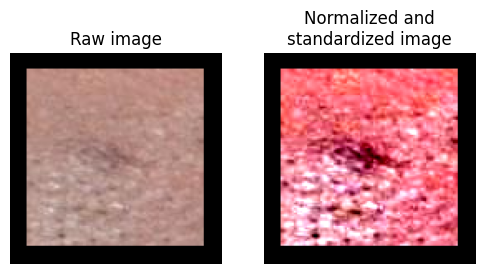

In [ ]:
for i in range(10):
  plot_normalized_and_normal_image(i)

In [ ]:
# TODO: implement a CNN

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * (max_img_size // 8) * (max_img_size // 8), 256)
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * (max_img_size // 8) * (max_img_size // 8))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
# not great because it assumes a cutoff of 0.5, but will be interesting to log nonetheless
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

device

device(type='cuda')

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        acc = binary_accuracy(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            acc = binary_accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
# Parameters for early stopping
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

num_epochs = 16
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Best model weights initialization
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        early_stop = True
        break

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/16
Train Loss: 0.7199, Train Acc: 0.5709
Val Loss: 0.6135, Val Acc: 0.7150
Epoch 2/16
Train Loss: 0.5485, Train Acc: 0.7281
Val Loss: 0.5196, Val Acc: 0.7283
Epoch 3/16
Train Loss: 0.5278, Train Acc: 0.7600
Val Loss: 0.4850, Val Acc: 0.7538
Epoch 4/16
Train Loss: 0.5017, Train Acc: 0.7653
Val Loss: 0.4200, Val Acc: 0.8108
Epoch 5/16
Train Loss: 0.4515, Train Acc: 0.8069
Val Loss: 0.3924, Val Acc: 0.8300
Epoch 6/16
Train Loss: 0.4403, Train Acc: 0.8187
Val Loss: 0.3913, Val Acc: 0.8425
Epoch 7/16
Train Loss: 0.4117, Train Acc: 0.8322
Val Loss: 0.3889, Val Acc: 0.8358
Epoch 8/16
Train Loss: 0.4004, Train Acc: 0.8338
Val Loss: 0.3649, Val Acc: 0.8617
Epoch 9/16
Train Loss: 0.3491, Train Acc: 0.8494
Val Loss: 0.3780, Val Acc: 0.8425
Epoch 10/16
Train Loss: 0.3101, Train Acc: 0.8753
Val Loss: 0.3960, Val Acc: 0.8488
Epoch 11/16
Train Loss: 0.2891, Train Acc: 0.8834
Val Loss: 0.3758, Val Acc: 0.8617
Epoch 12/16
Train Loss: 0.2677, Train Acc: 0.8981
Val Loss: 0.4332, Val Acc: 0.8358
E

<All keys matched successfully>

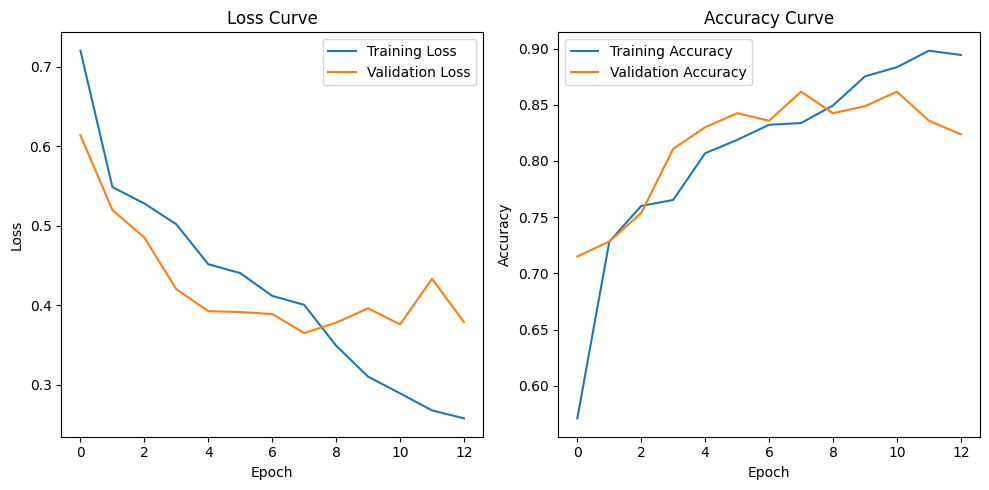

In [ ]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

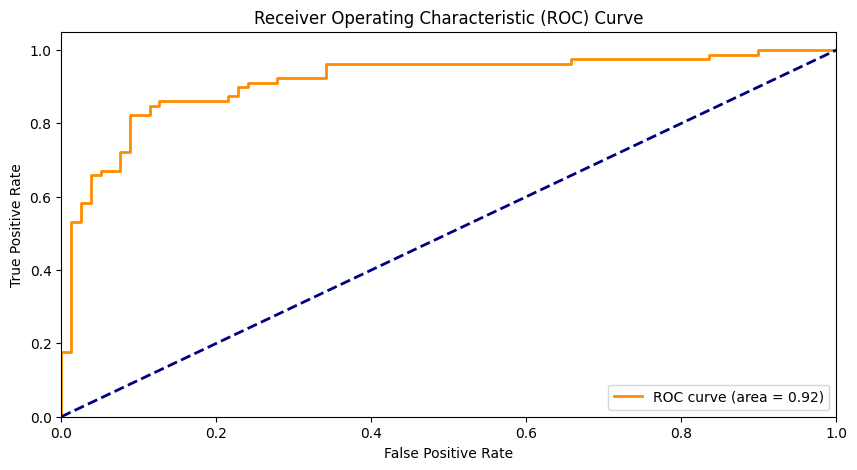

Optimal Threshold: 0.61


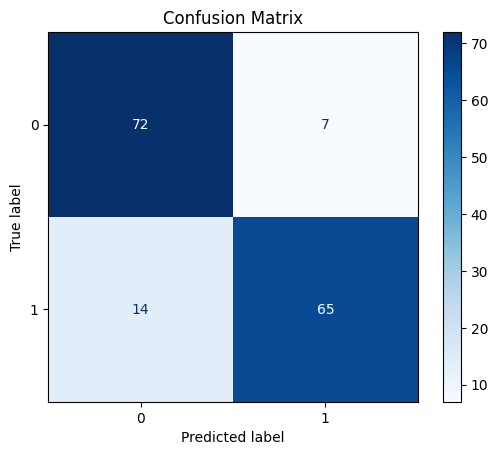

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Function to get predictions and true labels from the dataloader
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    return all_preds, all_labels

# Get predictions and true labels
val_preds, val_labels = get_predictions_and_labels(model, val_dataloader, device)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Check if this index is appropriate
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.2f}')

# Calculate confusion matrix using optimal threshold
val_preds_binary = [1 if pred >= optimal_threshold else 0 for pred in val_preds]
cm = confusion_matrix(val_labels, val_preds_binary)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()